In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v2 import keras
from tensorflow.compat.v2.keras import layers
import tensorflow_datasets as tfds

In [3]:
%tensorflow_version 2.x
print(tf.__version__)
!nvidia-smi
tf.enable_v2_behavior()

2.2.0-rc2
Tue Apr 14 03:04:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory 

In [4]:
train_data = tfds.load(name="cifar10", split='train[100:]',  data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')
valid_data = tfds.load(name="cifar10", split='train[:100]',  data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')
test_data = tfds.load(name="cifar10", split='test', data_dir='/content/drive/My Drive/Colab Notebooks/tensorflow-datasets')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/cifar10/3.0.0.incompleteD9Q1D4/cifar10-train.tfrecord


Shuffling and writing examples to /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/cifar10/3.0.0.incompleteD9Q1D4/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /content/drive/My Drive/Colab Notebooks/tensorflow-datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [0]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = 50000-100
train_data = train_data.shuffle(train_num)  # 打散資料集
# 載入前面的資料預處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-2（卷積神經網路）
建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [7]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [0]:
model_dir = '/content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models'  # 設定儲存權重目錄
if os.path.exists(model_dir) == False:
    os.makedirs(model_dir)  # 創建儲存權重目錄
# 儲存訓練記錄檔
log_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/tensorflow-datasets/lab4-logs/models' , 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [0]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [10]:
history_2 = model_2.fit(train_data,
                        epochs=10, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/10
780/780 [==============================] - 9s 11ms/step - loss: 1.8947 - categorical_accuracy: 0.2830 - val_loss: 1.7597 - val_categorical_accuracy: 0.3800
Epoch 2/10
780/780 [==============================] - 8s 10ms/step - loss: 1.5418 - categorical_accuracy: 0.4410 - val_loss: 1.4378 - val_categorical_accuracy: 0.5000
Epoch 3/10
780/780 [==============================] - 8s 11ms/step - loss: 1.3552 - categorical_accuracy: 0.5163 - val_loss: 1.2245 - val_categorical_accuracy: 0.5600
Epoch 4/10
780/780 [==============================] - 9s 11ms/step - loss: 1.2186 - categorical_accuracy: 0.5697 - val_loss: 1.1374 - val_categorical_accuracy: 0.6100
Epoch 5/10
780/780 [==============================] - 8s 10ms/step - loss: 1.1216 - categorical_accuracy: 0.6078 - val_loss: 1.0770 - val_categorical_accuracy: 0.5700
Epoch 6/10
780/780 [==============================] - 9s 11ms/step - loss: 1.0452 - categorical_accuracy: 0.6331 - val_loss: 1.0346 - val_categorical_accuracy: 0.670

In [11]:
loss, acc = model_2.evaluate(test_data)
print('\nModel-2 Accuracy: {}%'.format(acc))

157/157 [==============================] - 3s 21ms/step - loss: 0.8607 - categorical_accuracy: 0.7085

Model-2 Accuracy: 0.7085000276565552%


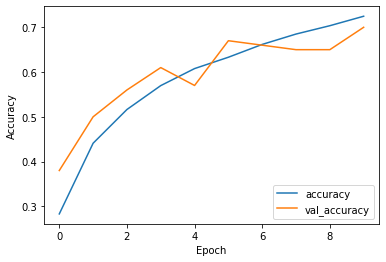

In [12]:
plt.plot(history_2.history['categorical_accuracy'], label='accuracy')
plt.plot(history_2.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')